In [2]:
# 24년 12월 11일
# commit 한 사람: 양채연
# 불필요한 코드 정리, 변수 선택 근거 통계자료, 잔차가 정규성을 띄는지 확인

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'AppleGothic'

In [4]:
train = pd.read_csv("FIFA_train.csv")
test = pd.read_csv("FIFA_test.csv")

남은 계약기간으로 변경

In [5]:
def con_period(x):
    if x == 'Dec 31, 2018' :
        return '2019'
    elif x == 'Jun 30, 2020' :
        return '2020.5'
    elif x == 'Jun 30, 2019' :
        return '2019.5'
    elif x == 'May 31, 2020' :
        return '2020.3333'
    elif x == 'May 31, 2019' :
        return '2019.3333'
    elif x == 'Jan 31, 2019' :
        return '2019.0833'
    elif x == 'Jan 1, 2019' :
        return '2019'
    elif x == 'Jan 12, 2019' :
        return '2019.034'
    elif x == 'Dec 31, 2019' :
        return '2020'
    elif x == 'Jun 1, 2019' :
        return '2019.416'
    else :
        return x

In [6]:
train.contract_until = train.contract_until.apply(con_period).astype('float64')
train.contract_until -= 2017

test.contract_until = test.contract_until.apply(con_period).astype('float64')
test.contract_until -= 2017

포지션도 수치형으로 변환

In [7]:
position_mapping = {
    'GK': 1,  # Goalkeeper
    'DF': 2,  # Defender
    'MF': 3,  # Midfielder
    'ST': 4   # Striker
}

train['position'] = train['position'].map(position_mapping)
test['position'] = test['position'].map(position_mapping)

회귀분석을 실행하기 위해 수치형 데이터만 남기기

In [8]:
train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,4.0,4,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,3.0,1,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,4.0,4,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,3.0,2,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,4.0,1,right,3.0,90,93,1.0,68000000.0


In [9]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   float64
 5   position          8932 non-null   int64  
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(4), int64(5), object(3)
memory usage: 837.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3828 entries, 0 to 3827
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------ 

In [10]:
#상관계수를 구하기 위해 수치형 변수만 선택하여 상관행렬 계산

In [11]:
# 수치형 변수만 선택
numeric_features = train.select_dtypes(include="number")

# 상관 행렬 계산
correlation_matrix = numeric_features.corr()

# value와 다른 변수의 상관 계수 정렬
correlation_with_value = correlation_matrix["value"].sort_values(ascending=False)
print("선수 가치(value)와 다른 변수들의 상관 계수:")
print(correlation_with_value)

선수 가치(value)와 다른 변수들의 상관 계수:
value               1.000000
reputation          0.665982
stat_overall        0.658444
stat_potential      0.611907
stat_skill_moves    0.298500
contract_until      0.235525
age                 0.087319
position            0.080808
id                 -0.544280
Name: value, dtype: float64


In [12]:
#상관계수 히트맵

/opt/anaconda3/envs/sda2024/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/opt/anaconda3/envs/sda2024/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


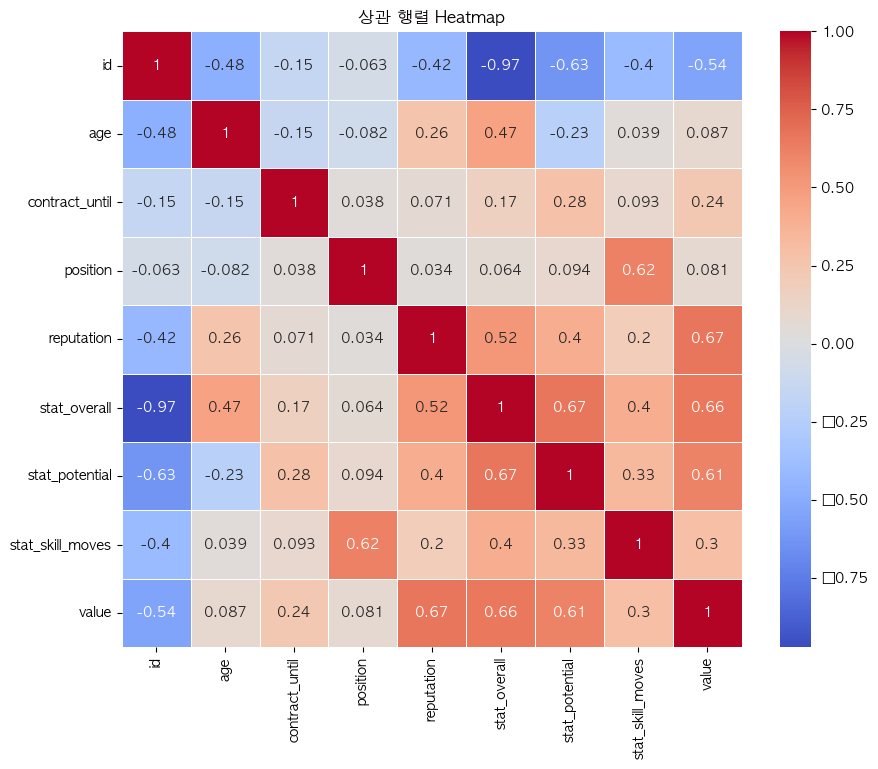

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("상관 행렬 Heatmap")
plt.show()

/var/folders/y5/19fcy0kj1tb71gkq4_4mx7xm0000gn/T/ipykernel_12736/973741907.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances, x="Importance", y="Feature", palette="coolwarm")


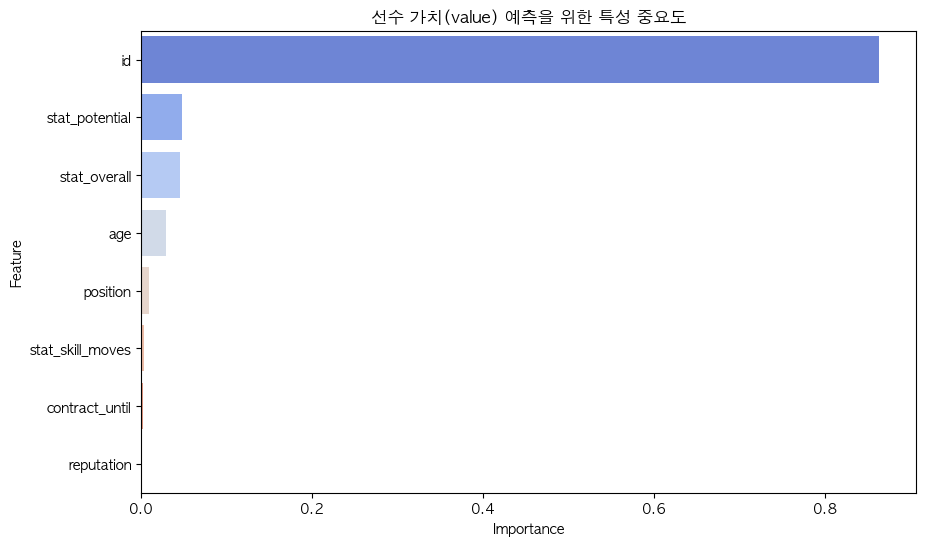

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# 특성과 타깃 설정
X = numeric_features.drop("value", axis=1)
y = numeric_features["value"]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 회귀 모델 학습
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 특성 중요도 시각화
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values (by="Importance", ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x="Importance", y="Feature", palette="coolwarm")
plt.title("선수 가치(value) 예측을 위한 특성 중요도")
plt.show()

In [15]:
import numpy as np

correlation = np.corrcoef(X_train['stat_overall'], y_train)[0, 1]

print(f"능력치와의 상관계수: {correlation}")

능력치와의 상관계수: 0.6660961617000616


In [16]:
correlation = np.corrcoef(X_train['stat_potential'], y_train)[0, 1]

print(f"잠재력과의 상관계수: {correlation}")

잠재력과의 상관계수: 0.6164791239354133


In [17]:
# 훈련 데이터에서 필요한 열 선택
X_train = train.drop(columns=['id', 'name', 'continent', 'prefer_foot', 'value'])
y_train = train['value']  # 종속 변수

# 테스트 데이터에서 동일한 열 선택
X_test = test.drop(columns=['id', 'name', 'continent', 'prefer_foot'])

회귀분석을 위한 시각화

In [18]:
X_train.head()

,age,contract_until,position,reputation,stat_overall,stat_potential,stat_skill_moves
0,31,4.0,4,5.0,94,94,4.0
1,27,3.0,1,4.0,91,93,1.0
2,31,4.0,4,5.0,91,91,3.0
3,32,3.0,2,4.0,91,91,3.0
4,25,4.0,1,3.0,90,93,1.0


In [19]:
def scatter(feature):
    plt.scatter(feature, y_train, alpha=0.7)
    plt.title("Feature vs Target")
    plt.xlabel("Feature")
    plt.ylabel("Target")
    plt.show()

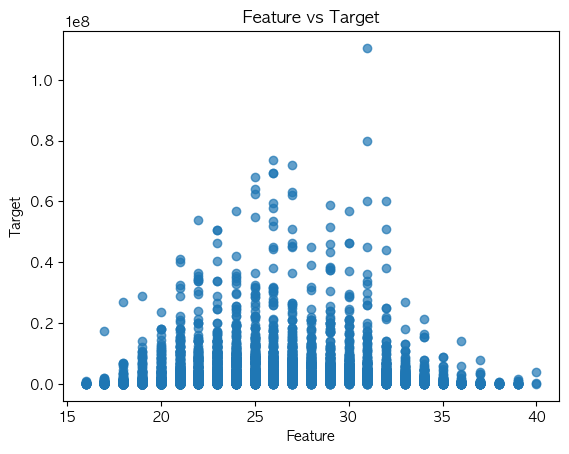

In [20]:
scatter(X_train['age'])

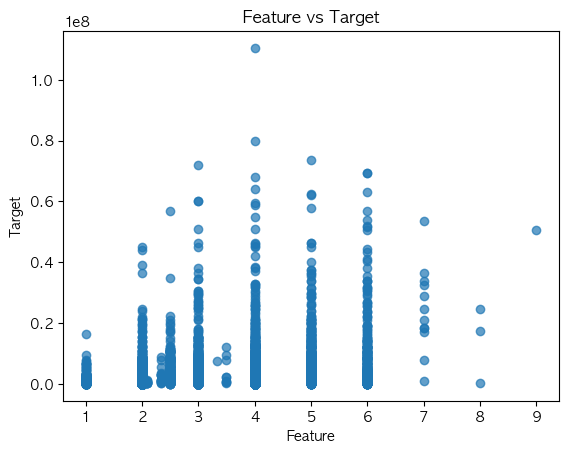

In [21]:
scatter(X_train['contract_until'])

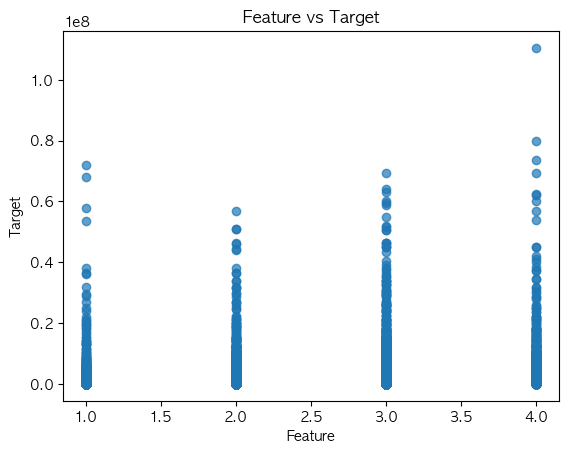

In [22]:
scatter(X_train['position'])

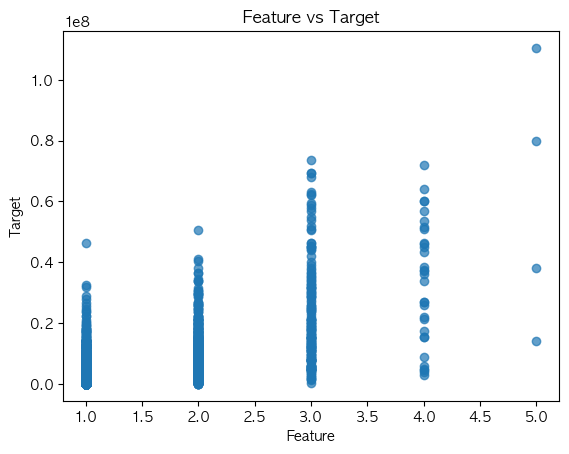

In [23]:
scatter(X_train['reputation'])

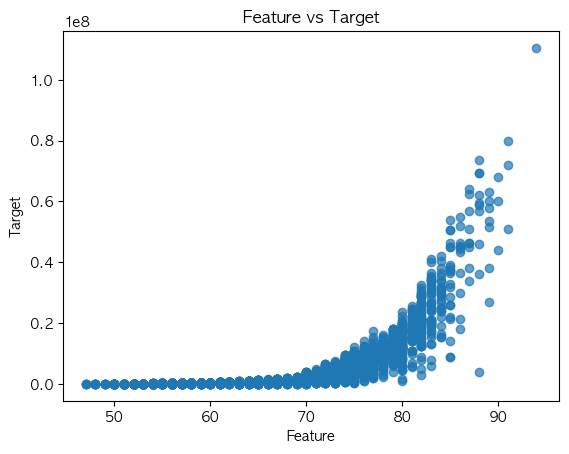

In [24]:
scatter(X_train['stat_overall'])

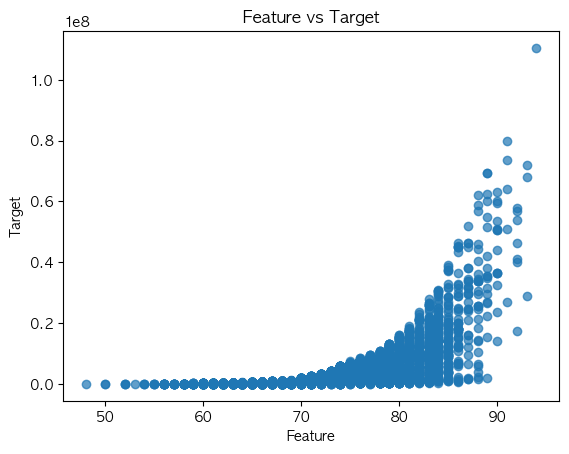

In [25]:
scatter(X_train['stat_potential'])

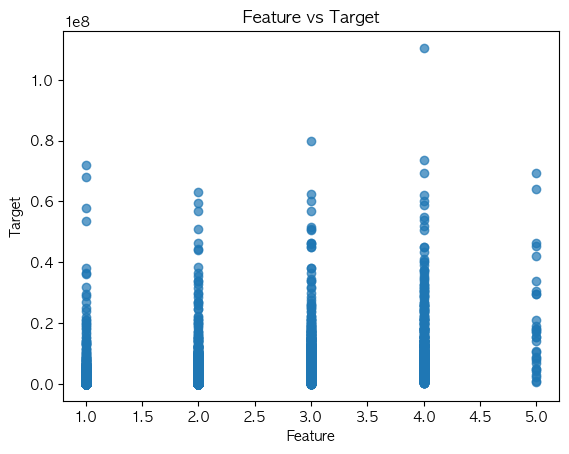

In [26]:
scatter(X_train['stat_skill_moves'])

선형성을 보이는 데이터가 없음 stat_overall을 로그 변환 시도

In [27]:
X_train_log = np.log1p(X_train)  # 독립 변수 로그 변환
y_train_log = np.log1p(y_train)

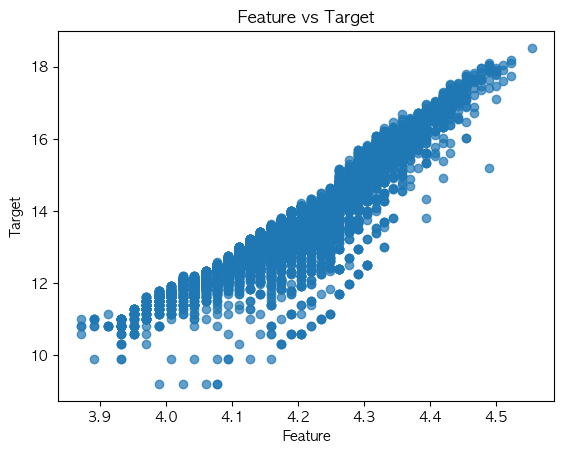

In [28]:
plt.scatter(X_train_log['stat_overall'], y_train_log, alpha=0.7)
plt.title("Feature vs Target")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.show()

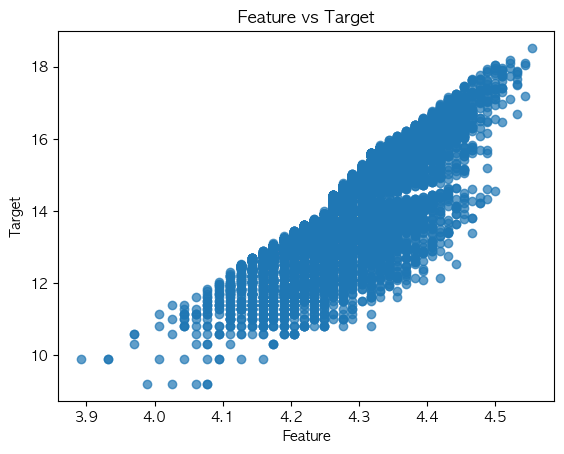

In [29]:
plt.scatter(X_train_log['stat_potential'], y_train_log, alpha=0.7)
plt.title("Feature vs Target")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.show()

In [50]:
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

# 데이터 준비 (이미 주어진 X_train1, y_train1 변수를 사용)
x_train1 = X_train_log['stat_overall']
y_train1 = y_train_log
x_test1 = np.log1p(X_test['stat_overall'])

# 학습 데이터를 훈련셋과 검증셋으로 분할
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    x_train1, y_train1, test_size=0.2, random_state=42
)

# 데이터가 1D인 경우, 2D로 변환
if len(X_val_split.shape) == 1:
    X_val_split = X_val_split.to_numpy().reshape(-1, 1)
if len(x_test1.shape) == 1:
    x_test1 = x_test1.to_numpy().reshape(-1, 1)
if len(x_train1.shape) == 1:
    x_train1 = x_train1.to_numpy().reshape(-1, 1)

# 절편(intercept) 추가 (statsmodels는 기본적으로 절편을 포함하지 않으므로 추가해야 함)
X_train_split = sm.add_constant(X_train_split)
X_val_split = sm.add_constant(X_val_split)
x_test1 = sm.add_constant(x_test1)

# statsmodels의 OLS 모델을 사용하여 학습
model = sm.OLS(y_train_split, X_train_split)

# 모델 학습
results = model.fit()

# 로버스트 표준 오차를 적용하여 회귀 분석
robust_results = model.fit(cov_type='HC3')

# 결과 출력
print(robust_results.summary())


                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                 4.009e+04
Date:                Wed, 11 Dec 2024   Prob (F-statistic):               0.00
Time:                        03:52:23   Log-Likelihood:                -5326.8
No. Observations:                7145   AIC:                         1.066e+04
Df Residuals:                    7143   BIC:                         1.067e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -40.1017      0.269   -149.061   

In [51]:
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

# 데이터 준비 (이미 주어진 X_train1, y_train1 변수를 사용)
x_train1 = X_train_log['stat_potential']
y_train1 = y_train_log
x_test1 = np.log1p(X_test['stat_potential'])

# 학습 데이터를 훈련셋과 검증셋으로 분할
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    x_train1, y_train1, test_size=0.2, random_state=42
)

# 데이터가 1D인 경우, 2D로 변환
if len(X_val_split.shape) == 1:
    X_val_split = X_val_split.to_numpy().reshape(-1, 1)
if len(x_test1.shape) == 1:
    x_test1 = x_test1.to_numpy().reshape(-1, 1)
if len(x_train1.shape) == 1:
    x_train1 = x_train1.to_numpy().reshape(-1, 1)

# 절편(intercept) 추가 (statsmodels는 기본적으로 절편을 포함하지 않으므로 추가해야 함)
X_train_split = sm.add_constant(X_train_split)
X_val_split = sm.add_constant(X_val_split)
x_test1 = sm.add_constant(x_test1)

# statsmodels의 OLS 모델을 사용하여 학습
model = sm.OLS(y_train_split, X_train_split)

# 모델 학습
results = model.fit()

# 로버스트 표준 오차를 적용하여 회귀 분석
robust_results = model.fit(cov_type='HC3')

# 결과 출력
print(robust_results.summary())


                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                 1.190e+04
Date:                Wed, 11 Dec 2024   Prob (F-statistic):               0.00
Time:                        03:52:45   Log-Likelihood:                -9020.2
No. Observations:                7145   AIC:                         1.804e+04
Df Residuals:                    7143   BIC:                         1.806e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -44.0671      0.527    -83.

/opt/anaconda3/envs/sda2024/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


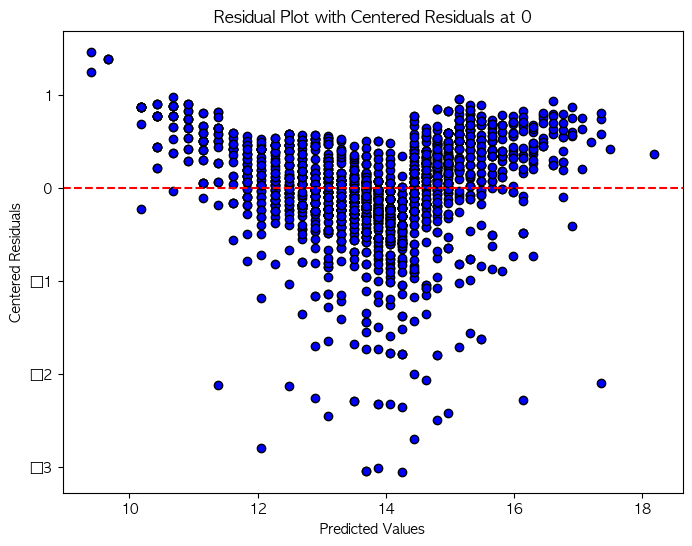

In [52]:
import matplotlib.pyplot as plt

residuals = y_val_split - y_pred_val  # Use correct true values (y_val_split)

residuals_centered_at_0 = residuals - residuals.mean()

# 잔차 그래프 그리기
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_val, residuals_centered_at_0, color='blue', edgecolor='black')
plt.axhline(y=0, color='red', linestyle='--')  # y=0에 기준선 그리기
plt.xlabel('Predicted Values')
plt.ylabel('Centered Residuals')
plt.title('Residual Plot with Centered Residuals at 0')
plt.show()

/opt/anaconda3/envs/sda2024/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


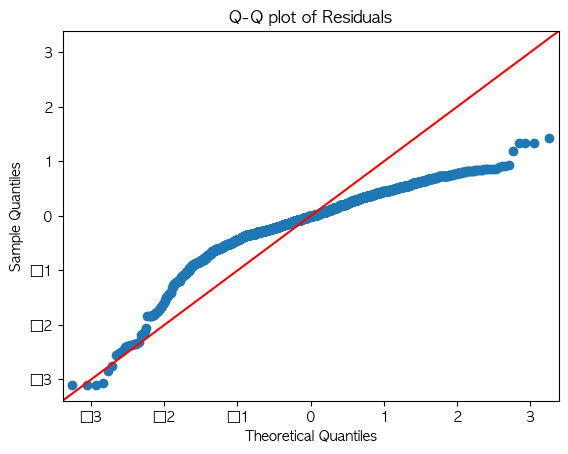

In [54]:
#잔차 정규성 qq plot 검증
sm.qqplot(residuals, line='45')
plt.title("Q-Q plot of Residuals")
plt.show()

In [55]:
from scipy.stats import shapiro

# Shapiro-Wilk Test
stat, p_value = shapiro(residuals)
print(f'Shapiro-Wilk Test Statistic: {stat}')
print(f'p-value: {p_value}')

if p_value > 0.05:
    print("잔차는 정규 분포를 따릅니다.")
else:
    print("잔차는 정규 분포를 따르지 않습니다.")

Shapiro-Wilk Test Statistic: 0.9051114320755005
p-value: 5.976168610795178e-32
잔차는 정규 분포를 따르지 않습니다.


In [69]:
# 검증 데이터에 대해 예측값 구하기
y_pred_val = robust_results.predict(X_val_split)

# 예측 결과 출력
print("예측된 이적료 (검증셋):")
print(y_pred_val)

# 예측된 값과 실제값을 비교
print("\n실제값과 예측값 비교:")
comparison = pd.DataFrame({'실제값': y_val_split, '예측값': y_pred_val})
print(comparison)

# 예측 성능 평가 (RMSE 계산)
from sklearn.metrics import mean_squared_error
rmse_val = np.sqrt(mean_squared_error(y_val_split, y_pred_val))
print(f"\n검증 데이터에 대한 RMSE: {rmse_val:.4f}")


예측된 이적료 (검증셋):
[12.87800274 13.46063995 13.83554368 ... 14.01916102 12.2690724
 14.37906678]

실제값과 예측값 비교:
            실제값        예측값
4309  13.304687  12.878003
4329  13.790194  13.460640
1897  12.254868  13.835544
4710  13.592368  13.460640
2225  15.297115  15.071304
...         ...        ...
1025  15.955577  14.729623
3146  14.557448  13.835544
6173  13.304687  14.019161
6182  13.071072  12.269072
7381  13.122365  14.379067

[1787 rows x 2 columns]

검증 데이터에 대한 RMSE: 0.8648


In [74]:
# 테스트 데이터셋에 대한 예측값 구하기
y_pred_test = robust_results.predict(x_test1)  # x_test1에 대한 예측값

# 예측값을 원래 값으로 변환 (로그 변환을 되돌림)
test['value'] = np.expm1(y_pred_test)

# 결과 확인
test[['name', 'stat_overall', 'value']]


,name,stat_overall,value
0,Cristiano Ronaldo,94,3.569559e+07
1,Neymar Jr,92,3.094509e+07
2,K. De Bruyne,91,2.678587e+07
3,E. Hazard,91,2.314952e+07
4,L. Modrić,91,2.314952e+07
...,...,...,...
3823,R. Takae,48,1.727891e+05
3824,L. Wahlstedt,48,2.617417e+05
3825,Y. Góez,48,2.617417e+05
3826,A. Kaltner,47,1.125727e+05
